# Speech Enhancement using DNN 


In [1]:

!pip install soundfile
!pip install audio-metadata



     |████████████████████████████████| 51kB 6.0MB/s 
     |████████████████████████████████| 163kB 21.8MB/s 
     |████████████████████████████████| 491kB 34.2MB/s 
  Created wheel for bitstruct: filename=bitstruct-8.11.1-cp36-cp36m-linux_x86_64.whl size=55389 sha256=cb160682887a8498e711917310a8c0cfa50c60bc4a0142502df8c7b16340c4ee
  Stored in directory: /root/.cache/pip/wheels/87/34/51/cae02bc88bc49160a5aaeeaad4a332b5a70cacb907de580a71
Successfully built bitstruct
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: attrs 20.3.0
    Uninstalling attrs-20.3.0:
      Successfully uninstalled attrs-20.3.0


In [6]:
%tensorflow_version 2.x
import tensorflow as tf
import librosa
import numpy as np
import soundfile as sf
import numpy as np
import wave
import librosa
import audio_metadata
import matplotlib.pyplot as plot
import IPython
import math
import scipy.io.wavfile
import librosa
import numpy as np
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import Conv2D, Input, LeakyReLU, Flatten, Dense, Reshape, Conv2DTranspose, BatchNormalization, Activation
from keras.models import Model
import tensorflow as tf 
import scipy.io.wavfile
import math



Found GPU at: /device:GPU:0


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

**Importation des fichiers Train/Test depuis le drive**





In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Lire le fichier bruit**

In [5]:
noise, samplerate_noise = sf.read('/content/drive/MyDrive/babble.wav')


In [6]:

pathAudio_train = "/content/drive/MyDrive/TIMIT_TRAIN_1"
pathAudio_test = "/content/drive/MyDrive/TIMIT_TEST"
files_train = librosa.util.find_files(pathAudio_train, ext=['WAV']) 
files_train = np.asarray(files_train)
files_test = librosa.util.find_files(pathAudio_test, ext=['WAV']) 
files_test = np.asarray(files_test)


**Lire tous le dataset , et couper chaque son en morceau de 3 sec , si le fichier fais moins de 3 sec on duplique à partir du début**

In [7]:
data_train=[]
data_test=[]

def cut(x):
  if len(x)>=3*samplerate-len(x):
    x=np.append(x,x[0:3*samplerate-len(x)])
  else:
    x=np.append(x,x)
    x=cut(x)
  return x
for f in files_train:
    x, samplerate  =  sf.read(f)
    if len(x)>3*samplerate:
      x=x[0:3*samplerate]
    else:
      x=cut(x)
      x=x[0:3*samplerate]
    data_train.append(x)

for f in files_test:
    x, samplerate  =  sf.read(f)
    if len(x)>3*samplerate:
      x=x[0:3*samplerate]
    else:
      x=cut(x)
      x=x[0:3*samplerate]
    data_test.append(x)


**Ci dessous une fonction qui prend chaque fichier audio , un coefficient de bruit entre 0 et 1 , et retourne les vecteurs Targets,Predictors,Phase du spectrogramme bruité et noisesound(correspondant au fichier bruité), on retourne ce fichier car on en aura besoin pour la comparaison avant/après des spectrogrammes**

In [9]:
def prediction(data,coeff_bruit):
        f, t, cleansoundstft = signal.stft(data, samplerate)
        position = random.randint(0,abs(len(noise) - len(data)))
        noised_Segment = noise[position:position + len(data)];
        alpha=coeff_bruit*math.sqrt(np.sum(np.power(data,2))/np.sum(np.power(noised_Segment,2)))
        noisedsound=data+alpha*noised_Segment
        f, t, noisedsoundstft = signal.stft(noisedsound, samplerate)
        phase=np.angle(noisedsoundstft)
        phase=np.transpose(phase,(1, 0))
        noisedsoundstft = abs(noisedsoundstft);
        cleansoundstft = abs(cleansoundstft);
        s=(np.shape(noisedsoundstft)[1],np.shape(noisedsoundstft)[0],8,1)
        s_target=(np.shape(cleansoundstft)[1],np.shape(cleansoundstft)[0],1)
        Target=np.zeros(s_target)
        predictor=np.zeros(s)
        for j in range(0,np.shape(cleansoundstft)[1]):
          Target[j,:,:]=cleansoundstft[:,j].reshape(129,1)
        for j in range(3,np.shape(noisedsoundstft)[1]-5):
           x=noisedsoundstft[:,j-3:j+5].reshape(129,8,1)
           predictor[j,:,:,:]=x          
        return predictor,Target,phase,noisedsound
        

**On prépare les vecteurs X_train ,Y_train ,X_test,Y_test l'entier 376 correspond à la largeur d'un spectrogramme de 3 sec (paramètre modifiable)**

In [10]:
X_train =np.zeros((376*len(data_train),129,8,1))
Y_train = np.zeros((376*len(data_train),129,1))
X_test=np.zeros((376*len(data_test),129,8,1))
Y_test=np.zeros((376*len(data_test),129,1))
for i in range(0,len(data_train)):
    predictor,target,phase,noisedsound=prediction(data_train[i])
    X_train[i:i+376,:,:,:]=predictor
    Y_train[i:i+376,:,:]=target

for i in range(0,len(data_test)):
    predictor,target,phase,noisedsound=prediction(data_test[i])
    X_test[i:i+376,:,:,:]=predictor
    Y_test[i:i+376,:,:]=target

**Normalisation des données avant propagation dans le réseau de neuronnes**

In [11]:
X_train=(X_train-np.min(X_train))/np.max(X_train)
Y_train=(Y_train-np.min(Y_train))/np.max(Y_train)
X_test=(X_test-np.min(X_test))/np.max(X_test)
Y_test=(Y_test-np.min(Y_test))/np.max(Y_test)

**Vérifier la forme des données**

In [12]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(376000, 129, 8, 1)
(376000, 129, 1)
(188000, 129, 8, 1)
(188000, 129, 1)


# Implementation du CNN

In [14]:
def build_model(l2_strength):
  inputs = Input(shape=[129, 8, 1])
  x = inputs

  # -----
  x = tf.keras.layers.ZeroPadding2D(((4,4), (0,0)))(x)
  x = Conv2D(filters=18, kernel_size=[9,8], strides=[1, 1], padding='valid', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  skip0 = Conv2D(filters=30, kernel_size=[10,3], strides=[1, 1], padding='same', use_bias=False,
                 kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(skip0)
  x = BatchNormalization()(x)

  x = Conv2D(filters=8, kernel_size=[9,8], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)




  # -----
  x = Conv2D(filters=18, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  skip1 = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
                 kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(skip1)
  x = BatchNormalization()(x)

  x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)




  # ----
  x = Conv2D(filters=18, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)
  
  x = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

    
    
    
  # ----
  x = Conv2D(filters=18, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
             kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = x + skip1
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)




  # ----
  x = Conv2D(filters=18, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
             kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = x + skip0
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

    
    
    
  # ----
  x = tf.keras.layers.SpatialDropout2D(0.2)(x)
  x = Conv2D(filters=1, kernel_size=[129,1], strides=[1, 1], padding='same')(x)

  model = Model(inputs=inputs, outputs=x)

  optimizer = tf.keras.optimizers.Adam(3e-4)
  #optimizer = RAdam(total_steps=10000, warmup_proportion=0.1, min_lr=3e-4)

  model.compile(optimizer=optimizer, loss='mse', 
                metrics=[tf.keras.metrics.RootMeanSquaredError('rmse')])
  return model

In [15]:
# Declare the model
model = build_model(l2_strength=0.0)
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 129, 8, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 137, 8, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 129, 1, 18)   1296        zero_padding2d[0][0]             
__________________________________________________________________________________________________
activation (Activation)         (None, 129, 1, 18)   0           conv2d[0][0]                     
______________________________________________________________________________________________

In [16]:
### Train the model
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, baseline=None)
model.fit(X_train,Y_train, batch_size = 100,epochs=100,validation_data=(X_test,Y_test)) 


Epoch 1/100
3760/3760 [==============================] - 49s 11ms/step - loss: 0.0397 - rmse: 0.1804 - val_loss: 0.5302 - val_rmse: 0.7281
Epoch 2/100
3760/3760 [==============================] - 38s 10ms/step - loss: 2.5015e-04 - rmse: 0.0157 - val_loss: 0.9512 - val_rmse: 0.9753
Epoch 3/100
3760/3760 [==============================] - 38s 10ms/step - loss: 6.0982e-05 - rmse: 0.0078 - val_loss: 0.4487 - val_rmse: 0.6699
Epoch 4/100
3760/3760 [==============================] - 38s 10ms/step - loss: 2.3446e-05 - rmse: 0.0048 - val_loss: 0.2357 - val_rmse: 0.4855
Epoch 5/100
3760/3760 [==============================] - 38s 10ms/step - loss: 9.3150e-06 - rmse: 0.0030 - val_loss: 0.0767 - val_rmse: 0.2769
Epoch 6/100
3760/3760 [==============================] - 39s 10ms/step - loss: 5.0527e-06 - rmse: 0.0022 - val_loss: 0.0131 - val_rmse: 0.1144
Epoch 7/100
3760/3760 [==============================] - 38s 10ms/step - loss: 2.8698e-06 - rmse: 0.0017 - val_loss: 0.0126 - val_rmse: 0.1123
Epo

**Enregistrement du modèle**


In [17]:
model.save('./denoiser_cnn_log_mel_majdou_generator.h5')


**Test sur un fichier donné**

In [88]:
IPython.display.Audio(audio,rate=samplerate)


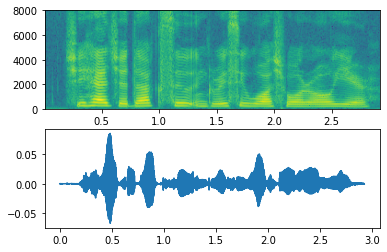

In [129]:
import matplotlib.pyplot as plot

audio, samplerate = sf.read('/content/drive/MyDrive/TIMIT_TRAIN_1/DR1/FCJF0/SA1.WAV') 
time=np.arange(0,len(audio)/samplerate,1/samplerate)
plot.subplot(211)
plot.specgram(audio,Fs=samplerate)
plot.subplot(212)
plot.plot(time,audio)


On gènère les prédicteurs correspondants , et on normalise .

    

In [130]:

stft,target,phase,noisy_sound=prediction(audio,1)
min=np.min(stft)
max=np.max(stft)
stft=(stft-min)/max


(367, 129, 8, 1)
(367, 129)


In [131]:
IPython.display.Audio(noisy_sound,rate=samplerate)


**Calcul de la distance spectrale avant débruitage**

In [132]:
f,t,stft_noisy=signal.stft(noisy_sound,samplerate)
f,t,stft_audio=signal.stft(audio,samplerate)
LSD_noised=math.sqrt((10*math.log(np.power(np.sum(abs(stft_noisy))/np.sum(abs(stft_audio)),2))))
print('LSD_noised='+str(LSD_noised))

LSD_noised=3.682941755853296


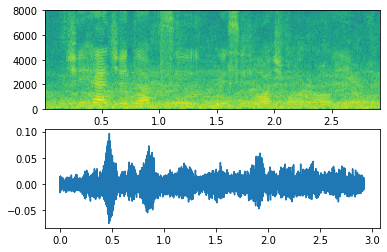

In [133]:
plot.subplot(211)
plot.specgram(noisy_sound,Fs=samplerate)
plot.subplot(212)
plot.plot(time,noisy_sound)



**Charger le modèle retenu et l'appliquer**

In [134]:
from keras import models    
from keras.models import load_model
model=models.load_model('/content/denoiser_cnn_log_mel_majdou_generator (2).h5')
stft_model=model.predict(stft)
stft_model=abs(stft_model)
stft_model=stft_model[:,:,0,0]
stft_model=stft_model*max+min


**Multiplier par la phase du spectrogramme bruité**

In [135]:
stft_model = np.multiply(stft_model,np.exp(1j * phase))


**Récupération du son**

46797


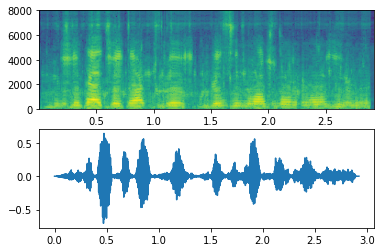

In [137]:
stft_model = np.transpose(stft_model, (1, 0))
_,originalsound = signal.istft(stft_model,samplerate)
plot.subplot(211)
plot.specgram(originalsound,Fs=samplerate)
originalsound=originalsound[0:len(audio)]
plot.subplot(212)
plot.plot(time,originalsound)
print(len(originalsound))

In [138]:
import IPython
IPython.display.Audio(originalsound,rate=samplerate)


In [139]:
f,t,stft_denoised=signal.stft(originalsound,samplerate)
LSD_denoised=math.sqrt((10*math.log(np.power(np.sum(abs(stft_denoised))/np.sum(abs(stft_audio)),2))))
print('LSD_denoised='+str(LSD_denoised))

LSD_denoised=6.391935740603567


**Tracés des courbes LSD pour train et test set**

In [141]:
LSD_train=[]
LSD_test=[]

def LSD_calcul(f):
  x, samplerate  =  sf.read(f)
  f,t,stft_audio=signal.stft(audio,samplerate)
  stft,target,phase,noisy_sound=prediction(audio,1)
  min=np.min(stft)
  max=np.max(stft)
  stft=(stft-min)/max
  stft_model=model.predict(stft)
  stft_model=abs(stft_model)
  stft_model=stft_model[:,:,0,0]
  stft_model=stft_model*max+min
  stft_model = np.multiply(stft_model,np.exp(1j * phase))
  stft_model = np.transpose(stft_model, (1, 0))
  LSD_denoised=math.sqrt((10*math.log(np.power(np.sum(abs(stft_model))/np.sum(abs(stft_audio)),2))))
  return LSD_denoised

In [151]:
pathAudio_train = "/content/drive/MyDrive/TIMIT_TRAIN_1"
pathAudio_test = "/content/drive/MyDrive/TIMIT_TEST"
files_train = librosa.util.find_files(pathAudio_train, ext=['WAV']) 
files_train = np.asarray(files_train)
files_test = librosa.util.find_files(pathAudio_test, ext=['WAV']) 
files_test = np.asarray(files_test)
files_train=files_train[0:500]
files_test=files_test[0:500]

In [152]:
LSD_train=[]
LSD_test=[]
for f in files_train:
  LSD_train=np.append(LSD_train,LSD_calcul(f))
for f in files_test:
  LSD_test=np.append(LSD_test,LSD_calcul(f))

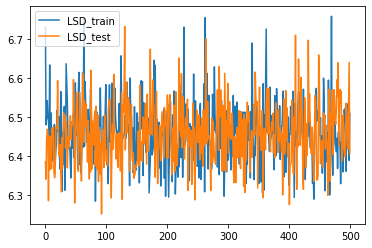

6.456980407151285 6.458917698348865


In [183]:
files=np.arange(len(files_test))
fig, ax = plt.subplots()
plt.plot(files, LSD_train,label='LSD_train')
plt.plot(files, LSD_test,label='LSD_test')
plt.legend()
plt.show()
print(np.mean(LSD_test),np.mean(LSD_train))